# Elements of Data Science

# COMS W4995 007 2018 3


## Week 6:  Data Cleaning, Feature Engineering and Natural Language Processing

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('white')

# To suppress FutureWarnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

np.random.seed(123)
%matplotlib 

Using matplotlib backend: Qt5Agg


## Reading: 

None, study for midterm

## Today

- Data Cleaning
    - Duplicates
    - Missing Values
    - Outliers

- Feature Engineering
    - Standardization 
    - Normalization
    - Binning
    - Dummy Variables, One-Hot encoding
    - Derived

- Natural Language Processing
    - Examples (sentiment analysis, entity extraction, ...)
    - BOW
    - TfIdf
    - Stopwords
    - Stemming and Lemmatization
    - N-Grams
    - Parse Trees

## Data Cleaning

### Duplicate Data

In [2]:
# taken from https://www.geeksforgeeks.org/python-pandas-dataframe-drop_duplicates/
taxi = pd.read_csv('../data/yellow_tripdata_2017-01_subset10000rows.csv', index_col=0)
taxi.rename({'tpep_pickup_datetime':'pickup_time',
           'tpep_dropoff_datetime':'dropoff_time'},
          axis='columns',
          inplace=True
         )

taxi = taxi.append(taxi.iloc[100,:])

In [3]:
sum(taxi.duplicated())

1

In [4]:
print(taxi.shape)
taxi2 = taxi.drop_duplicates()
print(taxi2.shape)

(10001, 17)
(10000, 17)


In [5]:
taxi = taxi.drop_duplicates(subset=['pickup_time','dropoff_time'])

### Missing data

In [6]:
shop = pd.read_csv('../data/week1_flowershop_data.csv')
sum(shop.price.isnull())

22

In [7]:
shop['price_missing'] = shop.price.isnull()

In [8]:
shop.price.median()

20.117401315382516

In [9]:
shop.price.fillna(shop.price.median(), inplace=True)
shop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
lastname           1000 non-null object
purchase_date      1000 non-null object
stars              1000 non-null int64
price              1000 non-null float64
favorite_flower    1000 non-null object
price_missing      1000 non-null bool
dtypes: bool(1), float64(1), int64(1), object(3)
memory usage: 40.1+ KB


### Outliers

- human data entry error
- instrument measurement errors
- data processing errors
- natural deviations

<img src='images/outlier-detection-1.png'>

<img src='images/Two-dimensional_Outliers_Example.png'>

<img src='images/higgs_outlier.png'>

#### Why worry about them?

- can throw off analysis
- can indicate issues

#### Detecting outliers

- understand your data!
- visualizations
- z-scores

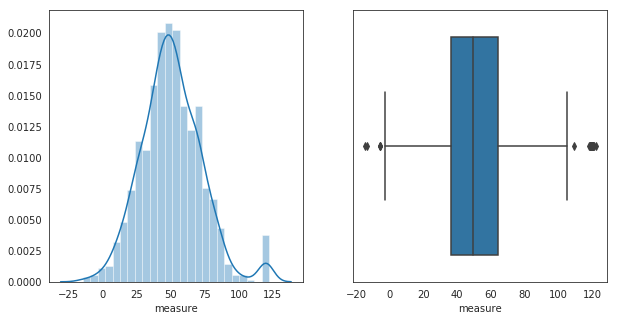

In [10]:
df = pd.DataFrame(np.random.normal(50,20,1000), columns=['measure'])
df = df.append(pd.DataFrame(np.random.normal(120,1,20), columns=['measure']))

fig,ax = plt.subplots(1,2, figsize=(10,5))
_ = sns.distplot(df.measure,ax=ax[0])
_ = sns.boxplot(df.measure,ax=ax[1])

#### z-score

In [11]:
df['measure_zscore'] = (df.measure - df.measure.mean()) / df.measure.std()

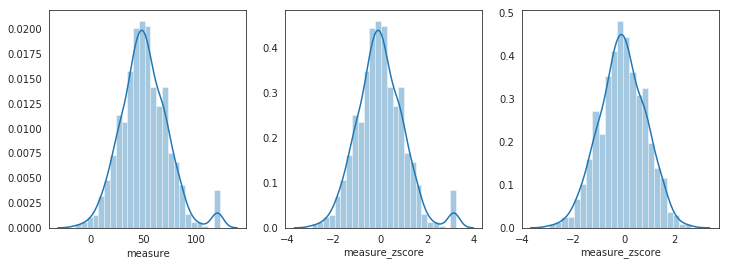

In [12]:
fig, ax = plt.subplots(1,3,figsize=(12,4))

_ = sns.distplot(df.measure,ax=ax[0])
_ = sns.distplot(df.measure_zscore, ax=ax[1])

keep_idx = np.abs(df.measure_zscore) < 3

_ = sns.distplot(df[keep_idx].measure_zscore, ax=ax[2])

In [13]:
from scipy.stats import zscore

In [14]:
df['measure_stats_zscore'] = zscore(df.measure)

In [15]:
df.iloc[0][['measure_zscore','measure_stats_zscore']]

measure_zscore         -1.008567
measure_stats_zscore   -1.009061
Name: 0, dtype: float64

In [16]:
df.measure.mean() == np.mean(df.measure)


True

In [17]:
df.measure.std() == np.std(df.measure)

False

In [18]:
df['measure_stats_zscore2'] = zscore(df.measure,ddof=1)
df.iloc[0][['measure_zscore','measure_stats_zscore2']]

measure_zscore          -1.008567
measure_stats_zscore2   -1.008567
Name: 0, dtype: float64

### Skewed Data

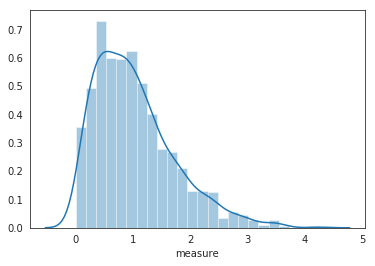

In [19]:
df = pd.DataFrame(np.random.gamma(2,.5,1000), columns=['measure'])

_ = sns.distplot(df.measure)

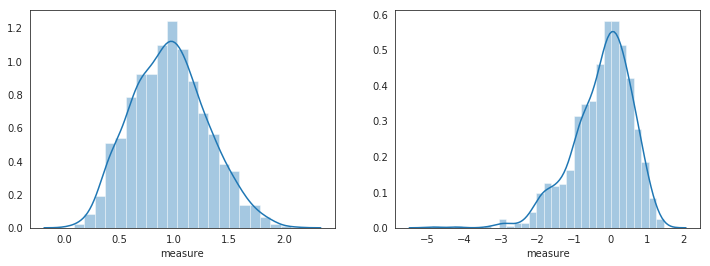

In [20]:
fig,ax = plt.subplots(1,2,figsize=(12,4))
_ = sns.distplot(df.measure.apply(np.sqrt), ax=ax[0])
_ = sns.distplot(df.measure.apply(np.log),  ax=ax[1])

In [21]:
df['measure_zscore'] = (df.measure - df.measure.mean()) / df.measure.std()
keep_idx = np.abs(df.measure_zscore) < 3

#### Many more parametric and non-parametric methods

- Standardized Residuals
- DBScan
- ElipticEnvelope
- IsolationForest
- other Anomoly Detection techniques

#### How to deal with outliers?

- drop data

- treat as missing and infer

## Feature Engineering

### Standardization

*transfrom to mean=0, std=1*

In [22]:
taxi = pd.read_csv('../data/yellow_tripdata_2017-01_subset10000rows.csv',
                parse_dates=['tpep_pickup_datetime','tpep_dropoff_datetime'])

taxi['trip_duration'] = (taxi.tpep_dropoff_datetime - taxi.tpep_pickup_datetime).dt.seconds

df = taxi[(taxi.trip_duration < 3600) & (taxi.tip_amount > 0) & (taxi.tip_amount < 10)]

df[['trip_duration','tip_amount']].describe()

,trip_duration,tip_amount
count,6184.000000,6184.000000
mean,756.319858,2.388745
std,509.359485,1.581928
min,2.000000,0.010000
25%,396.000000,1.360000
50%,625.000000,2.000000
75%,987.000000,2.850000
max,3572.000000,9.990000


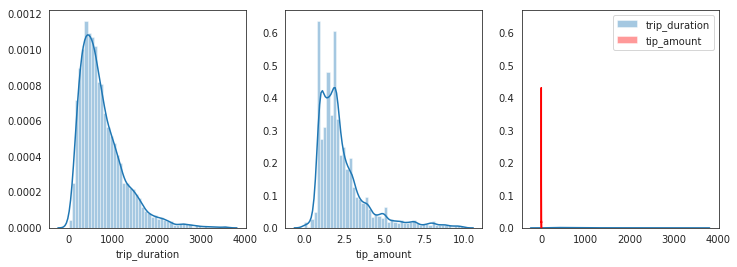

In [23]:
fig, ax = plt.subplots(1,3,figsize=(12,4))
_ = sns.distplot(df.trip_duration, ax=ax[0])
_ = sns.distplot(df.tip_amount, ax=ax[1])

_ = sns.distplot(df.trip_duration, ax=ax[2])
_ = sns.distplot(df.tip_amount, ax=ax[2], color='r')

_ = plt.xlabel('')
_ = plt.legend(['trip_duration','tip_amount'])

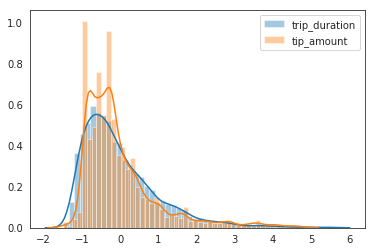

In [24]:
_ = sns.distplot(zscore(df.trip_duration))
_ = sns.distplot(zscore(df.tip_amount))
_ = plt.xlabel('')
_ = plt.legend(['trip_duration','tip_amount'])

In [25]:
from sklearn.preprocessing import StandardScaler

In [26]:
ss = StandardScaler()
ss.fit(taxi[['trip_duration','tip_amount']])
X = ss.transform(taxi[['trip_duration','tip_amount']])
X

array([[-0.29511619, -0.7351556 ],
       [-0.13997817,  0.04615789],
       [-0.32084822, -0.7351556 ],
       ...,
       [-0.19367979, -0.7351556 ],
       [ 0.12144432,  0.51494598],
       [-0.0844119 ,  0.10950763]])

In [27]:
X = StandardScaler().fit_transform(taxi[['trip_duration','tip_amount']])
X

array([[-0.29511619, -0.7351556 ],
       [-0.13997817,  0.04615789],
       [-0.32084822, -0.7351556 ],
       ...,
       [-0.19367979, -0.7351556 ],
       [ 0.12144432,  0.51494598],
       [-0.0844119 ,  0.10950763]])

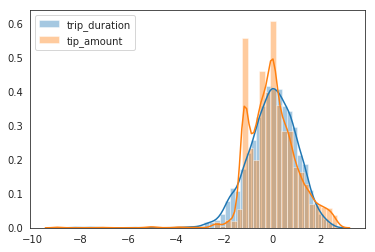

In [28]:
# deal with skew before standardizing

_ = sns.distplot(zscore(df.trip_duration.apply(np.log)))
_ = sns.distplot(zscore(df.tip_amount.apply(np.log)))
_ = plt.xlabel('')
_ = plt.legend(['trip_duration','tip_amount'])

### Normalization

*map into 0-1*

In [29]:
from sklearn.preprocessing import MinMaxScaler

In [30]:
X = MinMaxScaler().fit_transform(taxi[['trip_duration','tip_amount']])
X

array([[0.00079918, 0.        ],
       [0.00561746, 0.05916214],
       [0.        , 0.        ],
       ...,
       [0.00394959, 0.        ],
       [0.01373671, 0.09465942],
       [0.00734323, 0.06395907]])

In [31]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

scaler  = StandardScaler(with_mean=True,    # substract mean
                        with_std=True)      # scale to unit variance

minmax  = MinMaxScaler(feature_range=[0,1]) # min and max

rscaler = RobustScaler(with_centering=True, # subtract median
                       with_scaling=True)   # scale to IQR

### Binning

*continuous to categorical*

In [32]:
trip_duration_bins = [taxi.trip_duration.min(),
                      taxi.trip_duration.median(),
                      taxi.trip_duration.quantile(0.75),
                      taxi.trip_duration.max(),
                     ]
taxi['trip_duration_binned'] = pd.cut(taxi.trip_duration, 
                                      bins=trip_duration_bins, 
                                      labels=['short','medium','long'])
taxi.trip_duration_binned.iloc[:10]

0     short
1     short
2       NaN
3    medium
4     short
5     short
6      long
7      long
8    medium
9     short
Name: trip_duration_binned, dtype: category
Categories (3, object): [short < medium < long]

### Dummy Variables, One-Hot encoding

*dealing with categorical variables*

In [33]:
shop2 = shop[shop.favorite_flower.isin(['iris','lilac','carnation'])].copy()
shop2.favorite_flower.head()

0         iris
1        lilac
2    carnation
3        lilac
4    carnation
Name: favorite_flower, dtype: object

**One-Hot Encoding**: 1 column per category, 1 if in category, 0 if not

In [34]:
pd.get_dummies(shop2.favorite_flower).head()

,carnation,iris,lilac
0,0,1,0
1,0,0,1
2,1,0,0
3,0,0,1
4,1,0,0


In [35]:
pd.get_dummies(shop2.favorite_flower, prefix='favoriteflower').head()

,favoriteflower_carnation,favoriteflower_iris,favoriteflower_lilac
0,0,1,0
1,0,0,1
2,1,0,0
3,0,0,1
4,1,0,0


In [36]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False)

In [37]:
X = pd.DataFrame([[0,0],[1,1],[0,2]])
X

,0,1
0,0,0
1,1,1
2,0,2


In [38]:
ohe.fit_transform(X)

array([[1., 0., 1., 0., 0.],
       [0., 1., 0., 1., 0.],
       [1., 0., 0., 0., 1.]])

### Transforming with Pipelines

In [39]:
from sklearn.preprocessing import Imputer

imputer = Imputer(strategy='mean') # mean, median, most_frequent

X = np.array([1,np.nan,2]).reshape(-1,1)

In [40]:
imputer.fit_transform(X)

array([[1. ],
       [1.5],
       [2. ]])

### Dataframe OneHotEncoding in Sklearn

In [41]:
shop2.favorite_flower.head()

0         iris
1        lilac
2    carnation
3        lilac
4    carnation
Name: favorite_flower, dtype: object

In [42]:
shop2['favorite_flower'] = shop2.favorite_flower.astype('category')
shop2.favorite_flower.head()

0         iris
1        lilac
2    carnation
3        lilac
4    carnation
Name: favorite_flower, dtype: category
Categories (3, object): [carnation, iris, lilac]

In [43]:
shop2.favorite_flower.cat.codes.head()

0    1
1    2
2    0
3    2
4    0
dtype: int8

In [44]:
shop2['favorite_flower_code'] = shop2.favorite_flower.cat.codes

In [45]:
list((i,x) for i,x in enumerate(shop2.columns))

[(0, 'lastname'),
 (1, 'purchase_date'),
 (2, 'stars'),
 (3, 'price'),
 (4, 'favorite_flower'),
 (5, 'price_missing'),
 (6, 'favorite_flower_code')]

In [46]:
from sklearn.preprocessing import FunctionTransformer

def get_categorical_cols(X):
    categorical_col_idxs = [6]
    return X[:,categorical_col_idxs]

def get_numerical_cols(X):
    real_col_idxs = [3]
    return X[:,real_col_idxs]

In [47]:
from sklearn.pipeline import Pipeline

In [48]:
cat_pipeline = Pipeline([('selector',FunctionTransformer(get_categorical_cols, validate=False)),
                         ('imputer',Imputer(strategy='most_frequent')),
                         ('onehot',OneHotEncoder())])

In [49]:
num_pipeline = Pipeline([('selector',FunctionTransformer(get_numerical_cols, validate=False)),
                         ('imputer',Imputer(strategy='median')),
                         ('robust_scaler',RobustScaler())])

In [50]:
from sklearn.pipeline import FeatureUnion

In [51]:
pipeline = FeatureUnion([('cat_pipeline',cat_pipeline),
                         ('num_pipeline',num_pipeline)])

In [52]:
pipeline.fit(shop2.values)

FeatureUnion(n_jobs=1,
       transformer_list=[('cat_pipeline', Pipeline(memory=None,
     steps=[('selector', FunctionTransformer(accept_sparse=False,
          func=<function get_categorical_cols at 0x7fd1951c97b8>,
          inv_kw_args=None, inverse_func=None, kw_args=None,
          pass_y='deprecated', validate=False)), (...stScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True))]))],
       transformer_weights=None)

In [53]:
X = pipeline.fit_transform(shop2.values)
X[0].todense()

matrix([[ 0.       ,  1.       ,  0.       , -0.0232995]])

### Derive and Find

- know your problem!

## Natural Language Processing

### Example Tasks

- sentiment analysis

- entity recognition

- machine translation

- natural language generation

- question answering

- relationship extraction

- automatic summarization

- ...

### Documents

- tweets
- reviews
- resumes
- books
- articles
- ...

**corpus**: a collection of documents

### How do we represent a document?

**terms**: the distinct values in our vocabulary ('aardvark','are','animal',...)

**tokens**: the strings that make up a document ('These','are','tokens','.')

**tokenization**: transforming a document into tokens.

### Bag of Words Representation

- split document into tokens
- ignoring order

**Term Frequency**: number of occurance of a term in a document

**Document Frequency**: number of documents a term occurs in

In [54]:
from sklearn.datasets import fetch_20newsgroups

ngs = fetch_20newsgroups()

In [55]:
docs = ngs['data'][:10]

In [56]:
docs[0]

"From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.\n\nThanks,\n- IL\n   ---- brought to you by your neighborhood Lerxst ----\n\n\n\n\n"

In [57]:
from sklearn.feature_extraction.text import CountVectorizer

In [58]:
cv = CountVectorizer()
X = cv.fit_transform([docs[0]])

In [59]:
X.todense()[0,:10]

matrix([[1, 1, 1, 1, 1, 2, 1, 1, 1, 1]], dtype=int64)

In [60]:
cv.get_feature_names()[:10]

['15',
 '60s',
 '70s',
 'addition',
 'all',
 'anyone',
 'be',
 'body',
 'bricklin',
 'brought']

**Stopwords**: uninformative terms we know we want to exclude (a, and, the, ...)

In [61]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

sorted(list(ENGLISH_STOP_WORDS))[:10]

['a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost']

In [62]:
cv = CountVectorizer(lowercase=True, stop_words='english')
X = cv.fit_transform([docs[0]])

In [63]:
cv.get_feature_names()[:10]

['15',
 '60s',
 '70s',
 'addition',
 'body',
 'bricklin',
 'brought',
 'bumper',
 'called',
 'car']

### Tf-Idf Representation

- term frequency - inverse document frequency
- downweight terms seen in many documents

In [64]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [65]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(docs[:10])
X.todense()[0,:10]

matrix([[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.07777143, 0.        ]])

### Stemming/Lemmatization

### How do we capture context?

**n_grams**: combinations of colocated terms

In [66]:
cv = CountVectorizer(ngram_range=(1,2))
X = cv.fit_transform([docs[0]])
cv.get_feature_names()[:10]

['15',
 '15 was',
 '60s',
 '60s early',
 '70s',
 '70s it',
 'addition',
 'addition the',
 'all',
 'all know']

**parse trees**: grammatical mapping of a sentence

**word2vec**: encode terms by their neighbors